# Exploratory Data Analysis

- [Accéder aux bases](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/)
- [Accéder à la documentation](https://www.data.gouv.fr/fr/datasets/r/8ef4c2a3-91a0-4d98-ae3a-989bde87b62a)

# Objectifs : prédire la gravité d'un accident

La gravité d'un accident est codée par la variable `grav`, présente (uniquement) dans la base _usagers_, qui peut prendre les valeurs suivantes :
- 1 : indemne ;
- 2 : tué ;
- 3 : blessé hospitalisé ;
- 4 : blessé léger.

On charge dans un premier temps tous les packages nécessaires.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Sur data.gouv, quatre bases de données sont publiées annuellement. Elles concernent : les usages, les véhicules, les lieux et les caractéristiques. Nous chargeons ci-dessous les quatre bases de 2021 (les plus récentes).

In [2]:
df_usagers_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8", sep=";")
df_vehicules_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/c9742921-4427-41e5-81bc-f13af8bc31a0", sep=";")
df_lieux_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995", sep=";")
df_caracs_22 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5fc299c0-4598-4c29-b74c-6a67b0cc27e7", sep=";")

df_usagers_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/ba5a1956-7e82-41b7-a602-89d7dd484d7a", sep=";")
df_vehicules_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0bb5953a-25d8-46f8-8c25-b5c2f5ba905e", sep=";")
df_lieux_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8a4935aa-38cd-43af-bf10-0209d6d17434", sep=";")
df_caracs_21 = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/85cfdc0c-23e4-4674-9bcd-79a970d7269b", sep=";")

c:\Users\nahta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
from data_cleaning import *

In [5]:
df_usagers_22 = clean_df_usagers(df_usagers_22)
df_vehicules_22 = clean_df_vehicules(df_vehicules_22)
df_lieux_22 = clean_df_lieux(df_lieux_22)
df_caracs_22 = clean_df_caracs(df_caracs_22)

df_usagers_21 = clean_df_usagers(df_usagers_21)
df_vehicules_21 = clean_df_vehicules(df_vehicules_21)
df_lieux_21 = clean_df_lieux(df_lieux_21)
df_caracs_21 = clean_df_caracs(df_caracs_21)

# Jointure

On s'assure qu'on a bien autant d'observations dont le triplet `(Num_Acc, id_vehicule, num_veh)` est unique dans les bases `usagers` et `véhicules`.

In [6]:
(~df_usagers_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

In [7]:
(~df_vehicules_22.duplicated(["Num_Acc", "id_vehicule", "num_veh"])).sum()

94493

À présent, on peut procéder à la jointure à l'aide de `pd.merge`. On joint d'abord les bases `usagers` et `vehicules` sur `(Num_Acc, id_vehicule, num_veh)`, puis on joint également les bases `lieux` et `caracs` sur l'identifiant de l'accident, codé par `Num_Acc`.

In [8]:
df_merged_22 = pd.merge(pd.merge(pd.merge(df_usagers_22, df_vehicules_22, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_22, on="Num_Acc"), df_caracs_22, on="Num_Acc")

On fait de même pour les autres années (2021).

In [9]:
df_merged_21 = pd.merge(pd.merge(pd.merge(df_usagers_21, df_vehicules_21, on=["Num_Acc", "id_vehicule", "num_veh"]), \
    df_lieux_21, on="Num_Acc"), df_caracs_21, on="Num_Acc")

In [11]:
df_merged = pd.concat([df_merged_21, df_merged_22], ignore_index=True)

In [13]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255910 entries, 0 to 255909
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      255910 non-null  int64  
 1   id_usager    255910 non-null  object 
 2   id_vehicule  255910 non-null  object 
 3   num_veh      255910 non-null  object 
 4   place        255910 non-null  int64  
 5   catu         255910 non-null  object 
 6   grav         255910 non-null  int64  
 7   sexe         250104 non-null  object 
 8   an_nais      249969 non-null  float64
 9   trajet       184462 non-null  object 
 10  secu1        255910 non-null  int64  
 11  secu2        255910 non-null  int64  
 12  secu3        255910 non-null  int64  
 13  locp         255910 non-null  int64  
 14  actp         131045 non-null  object 
 15  etatp        255910 non-null  object 
 16  senc         254999 non-null  float64
 17  catv         255219 non-null  float64
 18  obs          255792 non-

On retombe bien sur un total de 126 662 observations, soit la longueur de la base usagers.

# Nettoyages

In [14]:
df_merged["grav"].replace({2: 4, 4: 2}, inplace=True)

Eliminons d'emblée certaines variables qui ne serviront pas au modèle de prédiction de la gravité.

In [15]:
df_merged.drop(["Num_Acc", "id_usager", "id_vehicule", "num_veh", "voie", "v1", "v2"], axis=1, inplace=True)

**[WARNING : pas forcément une bonne idée car `catu` est parfois peut-être plus pertinent que `place`]**
On élimine également la variable `catu` qui posera des problèmes de colinéarité, car son information est redondante par rapport à la variable `place`.

In [16]:
df_merged.drop("catu", axis=1, inplace=True)

In [17]:
df_merged.columns

Index(['place', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3',
       'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv',
       'motor', 'occutc', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1',
       'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ', 'vma', 'jour',
       'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int', 'atm', 'col',
       'adr', 'lat', 'long', 'heure'],
      dtype='object')

Description des variables
- `place` : place occupée dans le véhicule par l'usager au moment de l'accident ; 1 conducteur, 10 piéton
- `sexe` : sexe de l'usager
- `an_nais` : année de naissance de l'usager
- `trajet` : motif du déplacement au moment de l'accident
- `secu` : présence et utilisation de tel équipement de sécurité
- `locp` : localisation du piéton
- `actp` : action du piéton
- `etatp` : piéton seul, accompagné ou en groupe
- `senc` : sens de circulation
- `catv` : catégorie du véhicule
- `obs` : obstacle fixe heurté
- `obsm` : obstacle mobile heurté
- `choc` : point de choc initial

# Statistiques descriptives

### Variable `agg`

On constate que
- la majorité des accidents de gravité 1 et 2 ont lieu en agglomération ;
- la majorité des accidents de gravité 3 et 4 ont lieu hors agglomération.

<AxesSubplot:xlabel='agg', ylabel='count'>

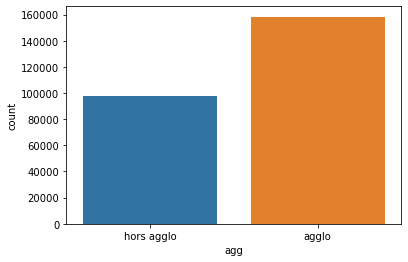

In [18]:
sns.countplot(data=df_merged, x="agg")

<AxesSubplot:xlabel='agg', ylabel='proportion'>

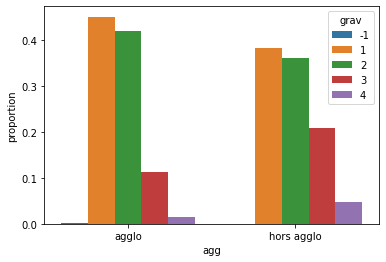

In [23]:
proportions = df_merged.groupby('agg')['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x='agg', y='proportion', hue='grav', data=proportions)

### Variable `place`

<AxesSubplot:xlabel='place', ylabel='count'>

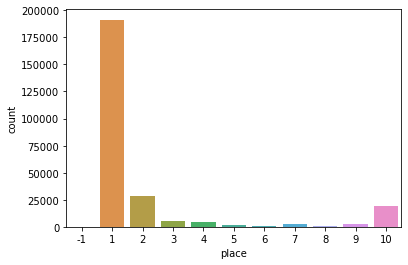

In [20]:
sns.countplot(data=df_merged, x="place")

<AxesSubplot:xlabel='place', ylabel='proportion'>

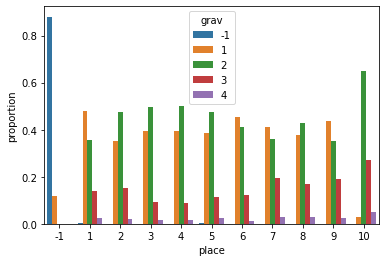

In [21]:
var = "place"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### Variable `catu`

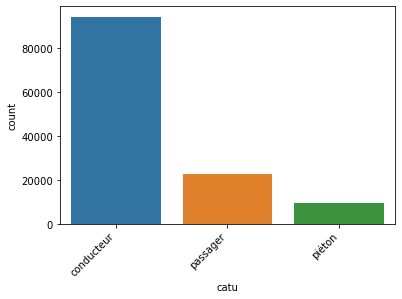

In [117]:
var = "catu"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

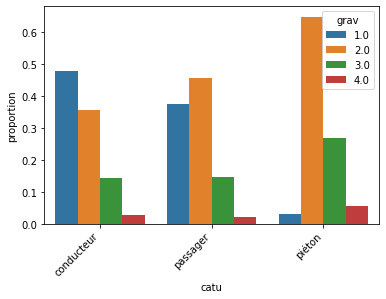

In [118]:
var = "catu"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### Variable `sexe`

<AxesSubplot:xlabel='sexe', ylabel='count'>

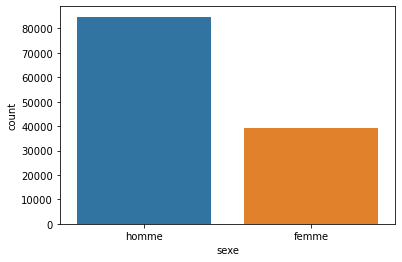

In [119]:
sns.countplot(data=df_merged, x="sexe")

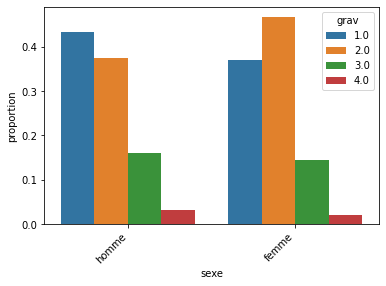

In [157]:
var = "sexe"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

### Variable `an_nais` (année de naissance)

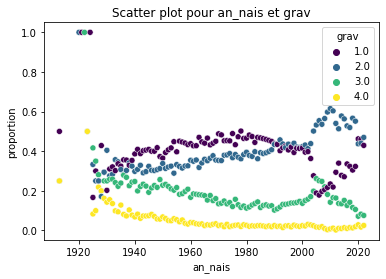

In [156]:
var = "an_nais"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.scatterplot(data=proportions, x=var, y='proportion', hue='grav', palette='viridis')
plt.title('Scatter plot pour an_nais et grav')
plt.show()

### Variable `nbv`

<AxesSubplot:xlabel='nbv', ylabel='count'>

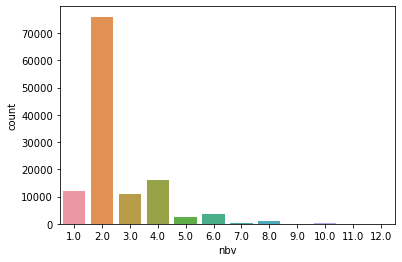

In [122]:
sns.countplot(data=df_merged, x="nbv")

<AxesSubplot:xlabel='nbv', ylabel='proportion'>

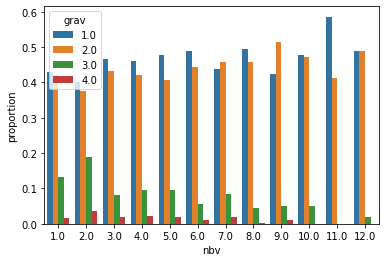

In [123]:
var = "nbv"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### Variable `trajet`

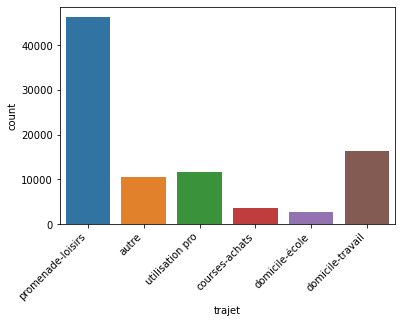

In [124]:
sns.countplot(data=df_merged, x="trajet")
plt.xticks(rotation=45, ha='right')
plt.show()

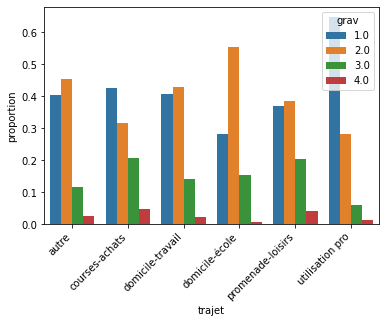

In [125]:
var = "trajet"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)
plt.xticks(rotation=45, ha='right')
plt.show()

### Variable `choc`

<AxesSubplot:xlabel='choc', ylabel='count'>

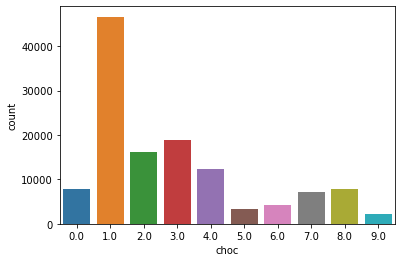

In [126]:
sns.countplot(data=df_merged, x="choc")

<AxesSubplot:xlabel='choc', ylabel='proportion'>

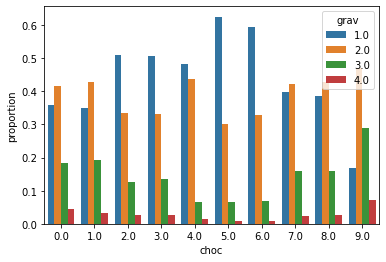

In [127]:
var = "choc"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### Variable `lum`

<AxesSubplot:xlabel='lum', ylabel='count'>

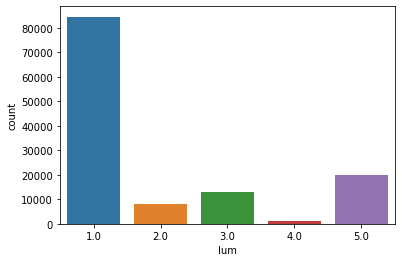

In [128]:
sns.countplot(data=df_merged, x="lum")

<AxesSubplot:xlabel='lum', ylabel='proportion'>

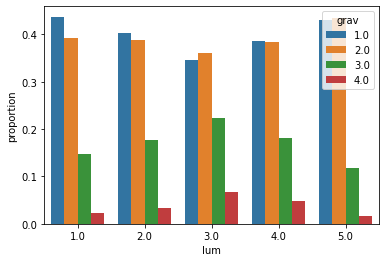

In [129]:
var = "lum"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions)

### Variable `surf` (surface)

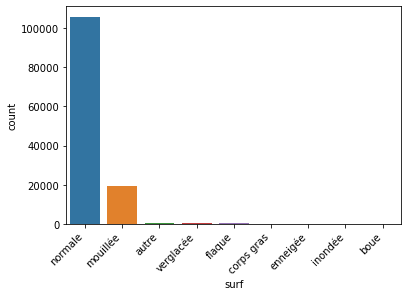

In [130]:
var = "surf"
sns.countplot(data=df_merged, x=var, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

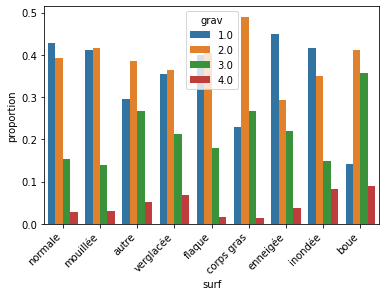

In [131]:
var = "surf"
proportions = df_merged.groupby(var)['grav'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x=var, y='proportion', hue='grav', data=proportions, order=df_merged[var].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

# Premiers modèles

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [132]:
df_elem1 = df_merged[["grav", "place", "an_nais", "lum", "vma", "trajet", "sexe", "agg"]]

df_elem1.dropna(inplace=True)

df_elem1

c:\Users\nahta\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,grav,place,an_nais,lum,vma,trajet,sexe,agg
0,3.0,1.0,2008.0,1.0,50.0,promenade-loisirs,homme,agglo
1,1.0,1.0,1948.0,1.0,50.0,promenade-loisirs,homme,agglo
2,2.0,1.0,1988.0,1.0,50.0,autre,homme,agglo
3,1.0,1.0,1970.0,1.0,50.0,utilisation pro,homme,agglo
5,2.0,1.0,1987.0,1.0,50.0,autre,femme,agglo
...,...,...,...,...,...,...,...,...
126656,4.0,1.0,1995.0,3.0,80.0,promenade-loisirs,homme,hors agglo
126657,1.0,1.0,2002.0,1.0,80.0,promenade-loisirs,femme,hors agglo
126658,3.0,8.0,2004.0,1.0,80.0,promenade-loisirs,femme,hors agglo
126659,2.0,1.0,1953.0,1.0,80.0,promenade-loisirs,femme,hors agglo


### KNeighbors

In [134]:
df_elem1 = df_merged[["grav", "catu", "an_nais", "lum", "vma", "trajet", "sexe", "agg"]]

df_elem1.dropna(inplace=True)

df_elem1

c:\Users\nahta\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,grav,catu,an_nais,lum,vma,trajet,sexe,agg
0,3.0,conducteur,2008.0,1.0,50.0,promenade-loisirs,homme,agglo
1,1.0,conducteur,1948.0,1.0,50.0,promenade-loisirs,homme,agglo
2,2.0,conducteur,1988.0,1.0,50.0,autre,homme,agglo
3,1.0,conducteur,1970.0,1.0,50.0,utilisation pro,homme,agglo
5,2.0,conducteur,1987.0,1.0,50.0,autre,femme,agglo
...,...,...,...,...,...,...,...,...
126656,4.0,conducteur,1995.0,3.0,80.0,promenade-loisirs,homme,hors agglo
126657,1.0,conducteur,2002.0,1.0,80.0,promenade-loisirs,femme,hors agglo
126658,3.0,passager,2004.0,1.0,80.0,promenade-loisirs,femme,hors agglo
126659,2.0,conducteur,1953.0,1.0,80.0,promenade-loisirs,femme,hors agglo


In [137]:
from sklearn.neighbors import KNeighborsClassifier

# Supposons que vous ayez un DataFrame df_elem1 avec les colonnes nécessaires
# Remplacez cela par votre DataFrame réel

# Séparation des features (X) et de la variable cible (y)
X = df_elem1.drop("grav", axis=1)
y = df_elem1["grav"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un transformateur pour les variables continues et catégorielles
numeric_features = ["an_nais", "vma"]
categorical_features = ["catu", "lum", "trajet", "sexe", "agg"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Créer le pipeline SVC avec le préprocesseur
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))  # Vous pouvez choisir un autre noyau selon vos besoins
])

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.49


### SVC

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Supposons que vous ayez un DataFrame df_elem1 avec les colonnes nécessaires
# Remplacez cela par votre DataFrame réel

# Séparation des features (X) et de la variable cible (y)
X = df_elem1.drop("grav", axis=1)
y = df_elem1["grav"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un transformateur pour les variables continues et catégorielles
numeric_features = ["an_nais", "vma"]
categorical_features = ["place", "lum"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Créer le pipeline SVC avec le préprocesseur
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear'))  # Vous pouvez choisir un autre noyau selon vos besoins
])

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.48
